# DEEE725 Speech Signal Processing Lab
### 2023 Spring, Kyungpook National University 
### Instructor: Gil-Jin Jang

## Lab 03 FIR filter design
2023/03/31
source: 

> https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.firwin.html

> https://coding-yoon.tistory.com/23

----
### common parts: import, analysis parameters, example wav file loading, etc.

In [1]:
# import necessary pacakages
# strange issue: keep the import order to prevent matplotlib error
#  import matplotlib -> librosa -> pyplot -> librosa.display
import sys
import numpy as np
import matplotlib
import librosa
from matplotlib import pyplot as plt
import librosa.display

#from scipy.io import wavfile
from scipy import signal
from scipy.fft import fftshift

신호 분석과 스펙트럼을 그리기 위한 다음의 parameter 들을 정의한다.
입력 파일의 sampling frequency 를 이용하여 shift size 를 sample 수로 정의하기 위해 사용된다.
- `Ts`: shift length in seconds, default 0.01 sec = 10 ms. 
- `Tf`: frame length in seconds, default 0.02 sec = 20 ms

In [2]:
# parameters for signal analysis
# Fs = 16000  native sampling frequency (wav file 에 정의된 것) 을 사용하면 필요 없음
Ts = 0.01   # 10 ms shift size
Tf = 0.02   # 20 ms frame size

spectrum 을 그리기 위한 parameters.
- `cmap_plot`: colormap. default value is `pyplot.cm.bone_r` (최소값 흰색, 최대값 검은색 의 gray scale) 

In [3]:
# parameters for drawing
#cmap_plot = plt.cm.bone # default colormap for spectrogram, gray
cmap_plot = plt.cm.bone_r # default colormap for spectrogram, gray, reversed
#cmap_plot = plt.cm.plasma 
#cmap_plot = plt.cm.inferno
#FIG_SIZE = (15,10)   # obsolete
FIG_SIZE = (8,3)

input file. 다른 파일을 사용하기 위해서는 이 부분을 변경하면 된다. 
- `wavfile`: file name
- `read_start`, `read_end`: 음성부분 시작과 끝. 파일마다 다르게 정의함

In [4]:
#wavfile, read_start, read_end = ('kdigits0-2.wav', 0.6, 1.1)
wavfile, read_start, read_end = ('gjang-kdigits0-3.wav', 1.0, 1.5)

__load an example windows wav file__
- `librosa.load()` 로 읽는다. 다른 package 들도 사용 가능. 
- `w = wave.open()`, `scipy.io.wavfile.read()`, 등 사용가능 
- 각 함수들에 따라 $-2^{15} \sim 2^{15} -1$, $-1 \sim 1$ 의 범위가 된다.
- `librosa.load()`는 $-1 \sim 1$
- 읽어들인 sampling frequency $F_s$ 를 이용하여 frame size $N_f$, shift size $N_s$를 계산한다.
- FFT (fast Fourier transform) 크기는 $N_f$ 보다 크거나 같은 2의 거듭제곱으로 FFT 크기 $N_{FFT}$ 을 정의함
$$ N_{FFT} = 2^{\lceil \log_{2} N_{f} \rceil} $$

In [5]:
# load audio file with Librosa
x, Fs = librosa.load(wavfile, sr=None, mono='True')
# sr: target sampling rate. ‘None’ uses the native sampling rate
# mono = True: convert signal to mono

print(x,x.shape)

Ns = int(Fs*Ts)    # shift number of samples
Nf = int(Fs*Tf)    # frame number of samples
NFFT = int(2**(np.ceil(np.log2(Nf))))   # Nf보다 크거나 같은 2의 거듭제곱을 NFFT 로 정의
print('Fs = %d, Ns = %d, Nf = %d, NFFT = %d' % (Fs, Ns, Nf, NFFT))

[-4.7912598e-03 -3.7231445e-03 -3.3569336e-03 ... -3.0517578e-05
 -8.8500977e-04  8.5449219e-04] (37952,)
Fs = 16000, Ns = 160, Nf = 320, NFFT = 512


In [6]:
x = x[int(Fs*read_start):int(Fs*read_end)]

---
### digital linear filter definition

- digital filter 는 most generally 다음과 같이 convolution 으로 정의된다.
$$ a * y = b * x \quad \Leftrightarrow \quad \sum_{k=0}^{N} a[k] y[n-k] = \sum_{m=0}^{M} b[m] x[n-m] $$ 
    - $M$, $N$: polynomial $b$, $a$의 order (coefficients 의 수는 $M+1$, $N+1$)
    - `a[0]` 은 amplification gain 의 역수가 된다.
$$ a[0] y[n] = \sum_{m=0}^{M} b[m] x[n-m] - \sum_{k=1}^{N} a[k] y[n-k] \quad \Leftrightarrow \quad y[n] = g \left( \sum_{m=0}^{M} b[m] x[n-m] - \sum_{k=1}^{N} a[k] y[n-k] \right) , \, g = 1/a[0] $$ 
    - 실용적으로는 나머지 계수들은 scaling 하여 `a[0] = 1.0` 으로 normalize 하여 사용한다.
$$ y[n] = \sum_{m=0}^{M} b[m] x[n-m] - \sum_{k=1}^{N} a[k] y[n-k] $$ 
- $z-$domain 에서는 
$$ A(z) Y(z) = B(z) X(z) \quad \Leftrightarrow \quad Y(z) = \frac{B(z)}{A(z)} X(z) $$ 
    - 한꺼번에 $H(z)$ 로 쓰기도 한다.
$$ H(z) = \frac{B(z)}{A(z)} =
\frac{b_{0} + b_{1} z^{-1} + \ldots + b_{M} z^{-M}}{a_{0} + a_{1} z^{-1} + \ldots + a_{N} z^{-N}} , \quad b_{m} = b[m], a_{k} = a[k] $$ 
    - 분모에 $z-$polynomial 이 있기 때문에 이를 approximate 하려면 무한대 길이의 polynomial 이 필요하다.
    - $H(z)$ 은 __IIR (infite impulse response)__ function
$$ h[n] = ? \quad \Rightarrow \textrm{infinite signal} $$

- 참고: $A(z) = 0$ 이 될 때 $H(z) \rightarrow \pm \infty$, 발산한다(IIR 의 infinite 와는 무관)
    - IIR filter를 실제 사용할 때는 매우 주의해야 한다. divergence detector (크기로) 등이 필요하다.
    - denominator (D), numerater (N) 표현도 자주 사용된다.
$$ H(z) = \frac{N(z)}{D(z)} $$ 


### linear filter function in `scipy` package  
See [scipy.signal.lfilter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html)

`scipy.signal.lfilter(b, a, x, axis=-1, zi=None)`

Filter data along one-dimension with an IIR or FIR filter. 
Filter a data sequence, x, using a digital filter. This works for many fundamental data types (including Object type). The filter is a direct form II transposed implementation of the standard difference equation (see Notes).

Parameters
1. `b` - The numerator coefficient vector in a 1-D sequence.
2. `a` - The denominator coefficient vector in a 1-D sequence. If a[0] is not 1, then both a and b are normalized by a[0].
3. `x` - An N-dimensional input array.

Returns
- `y` - The output of the digital filter.

```
a[0]*y[n] = b[0]*x[n] + b[1]*x[n-1] + ... + b[M]*x[n-M]
                      - a[1]*y[n-1] - ... - a[N]*y[n-N]
```

- 적절한 `a`, `b` 계수들을 가지고 있으면 위의 함수를 쓰면 된다.
    - 그러면 `a`, `b` 계수들을 어떻게 구하는가?
    - 공학적으로 IIR filter를 다루기 어렵기 때문에 충분히 tab size 가 큰 FIR filter 를 사용한다.
    - FIR filter 계수를 구하는 방법을 소개한다.

---
### FIR filter design basics

- behaviors of (general) IIR filters 
    > 가끔 IIR filter를 분모만 있는 $\frac{1}{A(z)}$ 로 언급하기도 하지만 엄밀하게는 분자 polynomial 도 있는 $\frac{B(z)}{A(z)}$를 IIR filter로 정의해야 한다    
$$ H(z) = \frac{B(z)}{A(z)} $$ 
    - $H(z) = 0$ if $B(z) = 0$ (zero, valley; __zero attenuation__)
    - $H(z) \rightarrow \infty$ if $A(z) = 0$ (pole, diverge; __infinite or exponential amplification__)
    - 앞의 입력의 영향을 많이 받는다(IIR 정의)

- behaviors of FIR filters 
    > $A(z) = 1 \Leftrightarrow a[0] = 1, a[1] = a[2] = \cdots = 0$ 
$$ H(z) = B(z) $$ 
    - $H(z) = 0$ if $B(z) = 0$ (zero, valley)
    - $M$ 개의 이전 sample 들만에게서 영향을 받는다.

- 원하는 필터 zero 만 있고 pole 이 필요없다면(즉, 아주 크게 amplification 할 필요가 없다면) FIR filter 를 사용하는 것이 안전하다.
    - FIR filter tab 을 크게 하면(length를 길게) 어느정도 IIR filter 를 approximation 가능. 

- FIR 에 적합한 digital filtering 의 예
    - lowpass / highpass / bandpass filter
    - $\pi = F_s / 2$
    - complex component 는 0이고 real component 는 frequency 0 에 대해서 대칭. 따라서 time domain 에서는 real 값만 있음 
    - real signal 에 대해서는 $0 \sim \pi$ 의 값만 사용하면 된다. 

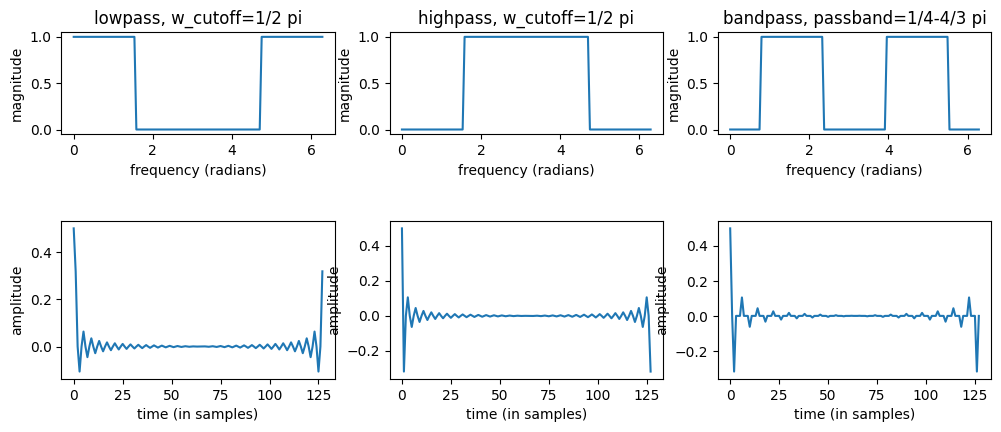

In [7]:
plt.figure(figsize=FIG_SIZE*np.array([1.5,1.5]))
Nf = 128  # 2 pi
xticks=np.linspace(0, np.pi*2, num=Nf, endpoint=True)

# draw frequence domain response
def plot_freqresponse(Y, freqticks):
    plt.plot(freqticks, Y.real)
    plt.xlabel('frequency (radians)')
    plt.ylabel('magnitude')

# draw time domain signal of the frequency response
def plot_timesignal(Y):
    plt.plot(np.fft.ifft(Y).real)
    plt.xlabel('time (in samples)')
    plt.ylabel('amplitude')

##############################################
# lowpass, cutoff frequency 1/2 pi
Y = np.concatenate((np.ones(Nf//4), np.zeros(Nf//2), np.ones(Nf//4)))**(1+0j)
plt.subplot(3,3,1)
plot_freqresponse(Y, xticks)
plt.title('lowpass, w_cutoff=1/2 pi')
plt.subplot(2,3,4)
plot_timesignal(Y)
    
##############################################
# highpass, cutoff frequency 1/2 pi
Y = np.concatenate((np.zeros(Nf//4), np.ones(Nf//2), np.zeros(Nf//4)))*(1+0j)
plt.subplot(3,3,2)
plot_freqresponse(Y, xticks)
plt.title('highpass, w_cutoff=1/2 pi')
plt.subplot(2,3,5)
plot_timesignal(Y)

##############################################
# lowpass, passband 1/2-3/4 pi
Y = np.concatenate((np.zeros(Nf//8), np.ones(Nf//4), np.zeros(Nf//8)))*(1+0j)
Y = np.concatenate((Y,Y))
plt.subplot(3,3,3)
plot_freqresponse(Y, xticks)
plt.title('bandpass, passband=1/4-4/3 pi')
plt.subplot(2,3,6)
plot_timesignal(Y)

---
### FIR filter implementation 

- lowpass, highpass, bandpass filter는 `scipy.signal` package 에 있는 함수를 사용하여 얻을 수 있다.
    1. 가장 일반적 [scipy.signal.firwin](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.firwin.html)
    2. [scipy.signal.firwin2](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.firwin2.html)
    3. least squares [scipy.signal.firls](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.firls.html)
    4. [scipy.signal.remez](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.remez.html)
- `MATLAB Signal Processing Toolbox`에도 `fir1`, `fir2`, `firls`, `firpm`, `remez` 등의 함수가 있다.(이쪽이 먼저임)
- 이중 가장 쉽게 사용할 수 있는 `firwin`을 이용하여 FIR 필터를 만들어 본다.

Text(0, 0.5, 'magnitude')

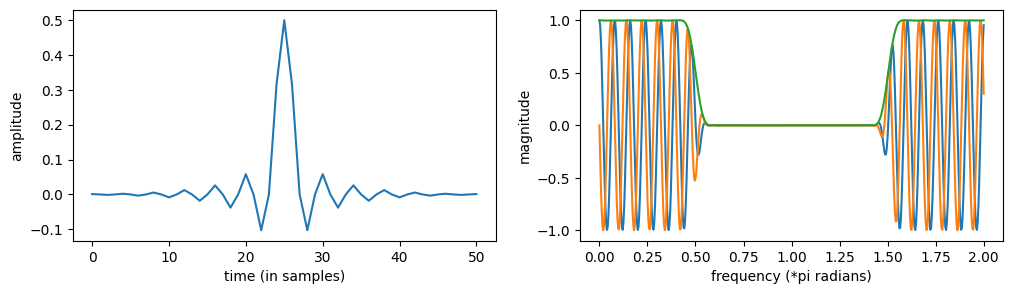

In [8]:
# scipy.signal.firwin(numtaps, cutoff, width=None, window='hamming', pass_zero=True, scale=True, nyq=None, fs=None)[source]
# FIR filter design using the window method.

# cutoff frequency 0.5 pi lowpass filter
a = signal.firwin(51, 0.5, window='hamming')
plt.figure(figsize=FIG_SIZE*np.array([1.5,1]))
plt.subplot(1,2,1)
plt.plot(a)
plt.xlabel('time (in samples)')
plt.ylabel('amplitude')
plt.subplot(1,2,2)
NFFT = 512
xticks=np.linspace(0, 2, num=NFFT, endpoint=True)
plt.plot(xticks, np.fft.fft(a, NFFT).real)
plt.plot(xticks, np.fft.fft(a, NFFT).imag)
plt.plot(xticks, np.abs(np.fft.fft(a, NFFT)))
plt.xlabel('frequency (*pi radians)')
plt.ylabel('magnitude')

1. time domain signal: 
    - real: symmetric at the center --> linear phase
        > A function is called linear phase if the phase response (output) of the filter is a linear function of frequency. 
        > Symmetric linear phase filters are very common, such as Wiener filters. 
        > An LTI system is minimum-phase if the system and its inverse are causal and stable (roots within a unit circle).
    - imaginary: anti-symmetric at the center --> real coefficient filter이기 때문에 모두 0
    - $A e^{ j \omega} = A ( \cos \omega + j \sin \omega) $
    - filter tab 은 홀수, 필터 order는 짝수로. 
    - 필터링 이후에는 order/2 만큼 shift 됨

2. frequency response
    - real, imaginary, 절대값을 그림 
    - __real__ symmetric at the center ($\pi$)
    - __imaginary__ anti-symmetric at the center ($\pi$)
    - __abs__ cutoff frequency $0.5 \pi$ 근처에서 부드럽게 변함 
    - Q: why tab = 51? (equivalently order = 50?)

filter order 를 바꿔 가면서 lowpass filter 비교 

In [9]:
def drawFIRWIN(numtabs, cutoff, pass_zero='lowpass', NFFT=512):
    # pass_zero = 'lowpass': lowpass
    # pass_zero = 'highpass': highpass
    a = signal.firwin(numtabs, cutoff, window='hamming', pass_zero=pass_zero)
    plt.subplot(1,2,1)
    plt.plot(a)
    plt.xlabel('time (in samples)')
    plt.ylabel('amplitude')
    plt.subplot(1,2,2)
    NFFT = max(numtabs, NFFT)
    xticks=np.linspace(0, 2, num=NFFT, endpoint=True)
    #plt.plot(xticks, np.fft.fft(a, NFFT).real)
    #plt.plot(xticks, np.fft.fft(a, NFFT).imag)
    plt.plot(xticks, np.abs(np.fft.fft(a, NFFT)))
    plt.xlabel('frequency (*pi radians)')
    plt.ylabel('magnitude')
    return a

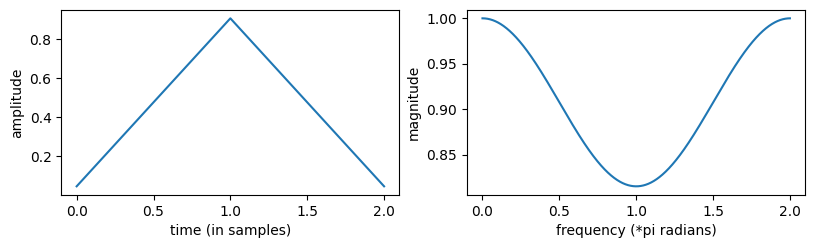

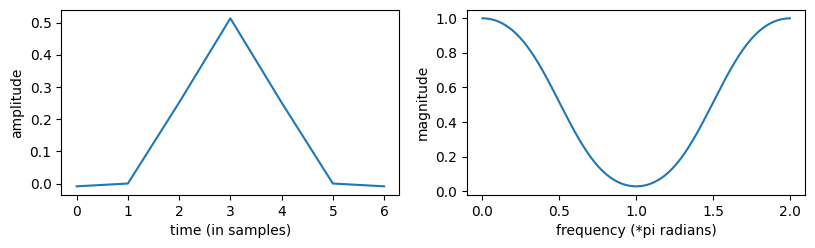

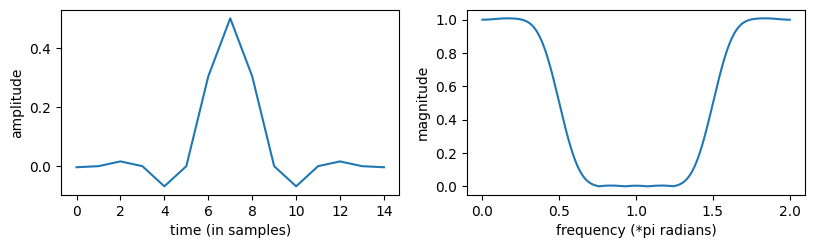

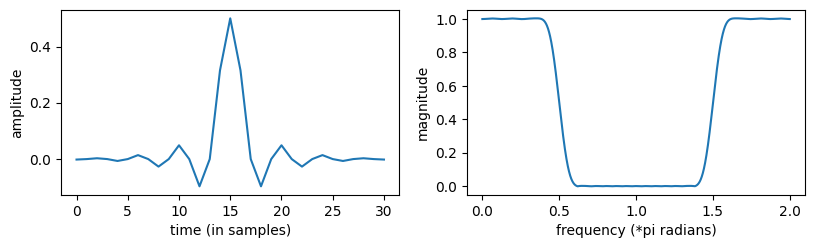

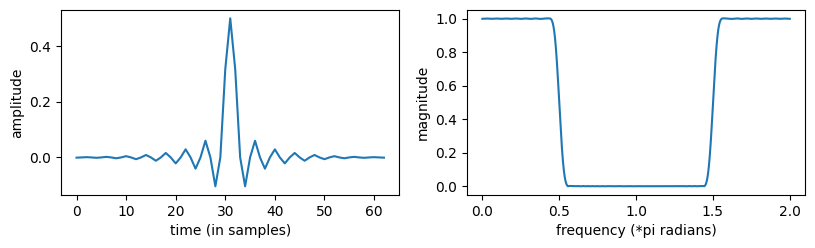

In [10]:
# lowpass
for nt in [3,7,15,31,63]:
    plt.figure(figsize=FIG_SIZE*np.array([1.2,0.8]))
    drawFIRWIN(nt, 0.5, NFFT=2048)    

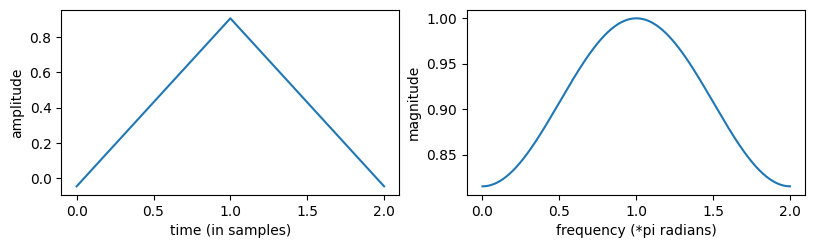

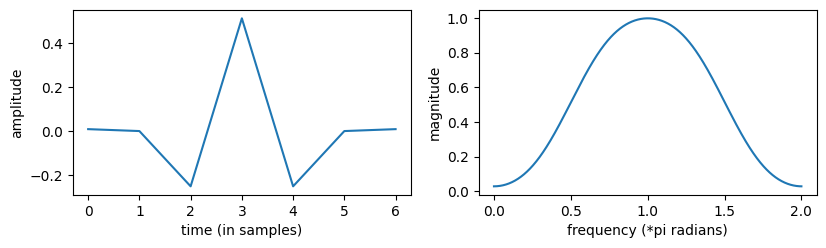

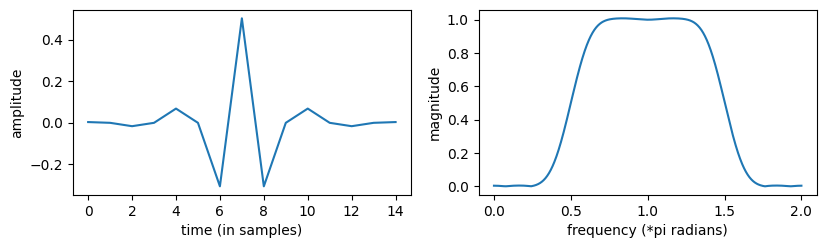

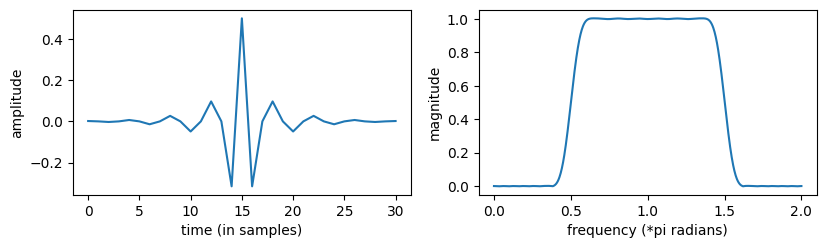

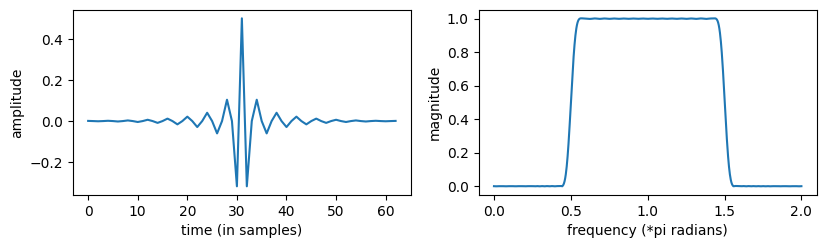

In [11]:
# highpass
for nt in [3,7,15,31,63]:
    plt.figure(figsize=FIG_SIZE*np.array([1.2,0.8]))
    drawFIRWIN(nt, 0.5, pass_zero='highpass', NFFT=1024)

- digital filter는 $z$ domain 에서 polynomial approximation. 따라서 order 가 높아질수록 sharp 하게 cutoff 가능.
- 다만 order 가 높아지면 직선이 구불구불해진다.
- lowpass filter는 averaging, highpass filter는 difference
- 모든 filter는 symmetric, shift order/2
- order 가 커지면 shift 도 커진다. 따라서 real-time system 에서는 이를 고려하여 정해야 함.

---
### FFT를 이용하여 linear phase FIR filter 만들기 

`scipy.signal` 에서 제공하지 않는 임의의 필터를 설계하는 방법 

1. $H(\omega) $ 원하는 frequency response를 0-pi 까지 만들기, NFFT/2+1 만큼
2. real 값 거울상으로 채워서 NFFT 채움
3. imaginary 값 모두 0으로 
2. IFFT $h[n] = F^{-1} H(\omega)$
5. 뒷 절반을 앞으로 이동 
6. $h[0]$ 를 중심으로 양쪽으로 order/2 만 선택
7. windowing (usually hamming)

각 주파수 성분값들로 filter의 frequency response가 주어졌을 때, `scipy.signal` 에서 제공하지 않는 임의의 필터를 설계하는 방법 
![FIRFFT design](figures/lab03_FIRFFT.png)

In [12]:
def getFIRFFT(H, order, winname=None):
    # H: NFFT/2+1
    NFFT = (len(H)-1)*2
    H = np.concatenate((H, H[-2:0:-1])) + np.zeros(NFFT)*(1j)
    h = np.fft.ifft(H, NFFT)
    order = min(NFFT-1, order)
    #h = np.concatenate((h[len(h)//2:], h[0:len(h)//2]))
    h = np.concatenate((h[(len(h)-order//2):], h[0:order//2+1]))
    if winname != None:
        win = librosa.filters.get_window(winname, order+1, fftbins=False)
        h = h*win
    return h.real

def drawFIRFFT(h, NFFT=512):
    plt.subplot(1,2,1)
    plt.plot(h)
    plt.xlabel('time (in samples)')
    plt.ylabel('amplitude')
    plt.subplot(1,2,2)
    NFFT = max(len(h), NFFT)
    xticks=np.linspace(0, 2, num=NFFT, endpoint=True)
    #plt.plot(xticks, np.fft.fft(a, NFFT).real)
    #plt.plot(xticks, np.fft.fft(a, NFFT).imag)
    plt.plot(xticks, np.abs(np.fft.fft(h, NFFT)))
    plt.xlabel('frequency (*pi radians)')
    plt.ylabel('magnitude')
    return h

# example
h = getFIRFFT(np.arange(33), 10, 'hamming')

Rectangular window 를 이용한 lowpass FIR filter 예제

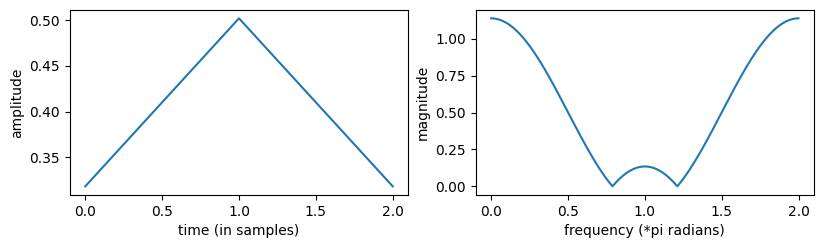

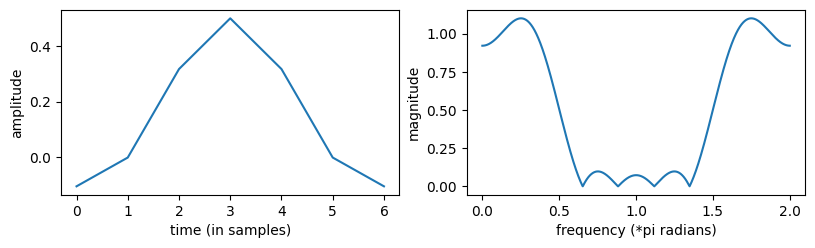

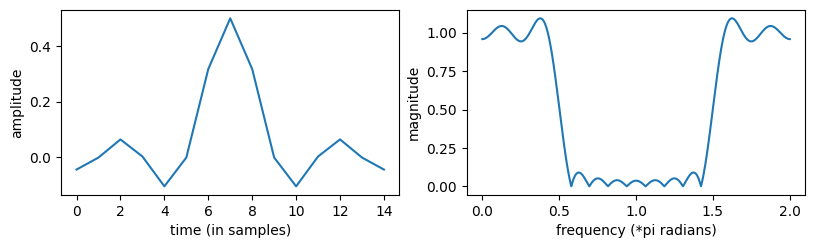

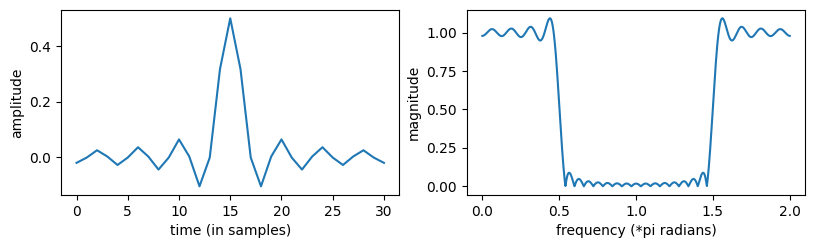

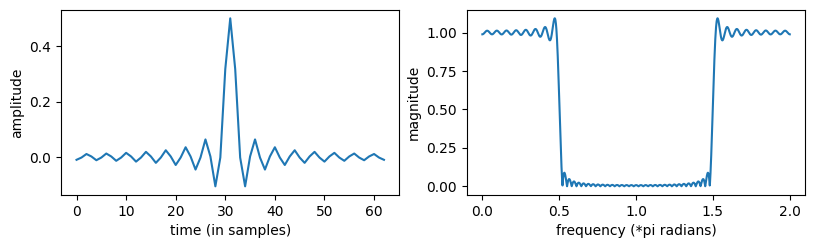

In [13]:
# lowpass 0.5, rectangular window
H = np.array([1.0]*129 + [0.0]*128)   # 512 길이의 0-pi
NffDraw = 2048
for order in [2, 6,14,30,62]:
    h = getFIRFFT(H, order)
    plt.figure(figsize=FIG_SIZE*np.array([1.2,0.8]))
    drawFIRFFT(h, NFFT=NffDraw)

Hamming window 를 이용한 lowpass FIR filter

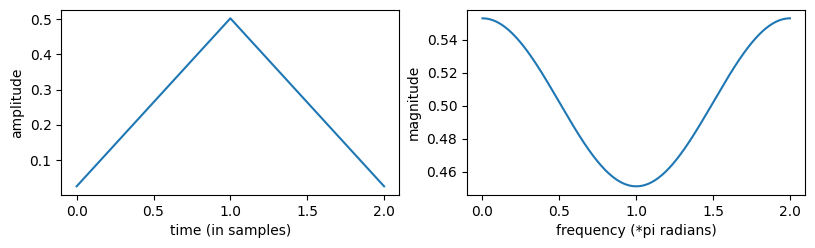

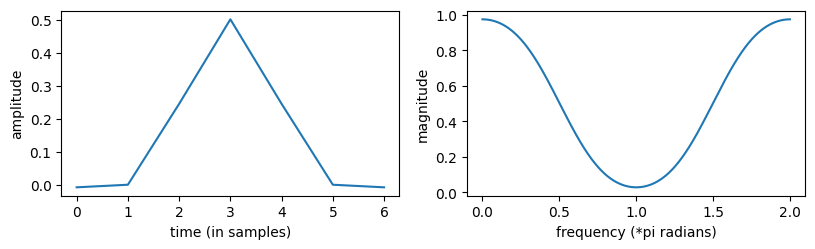

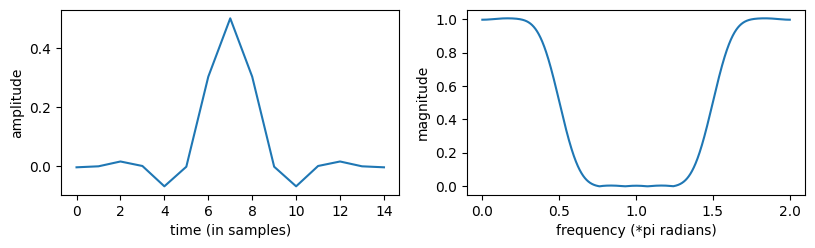

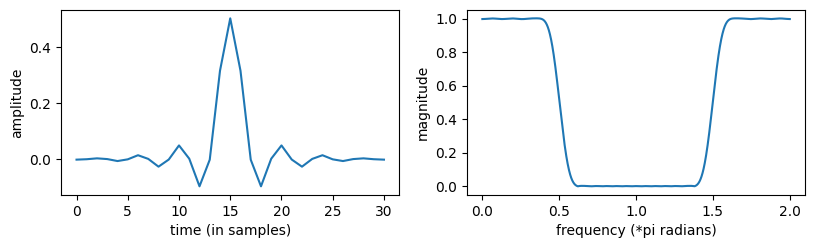

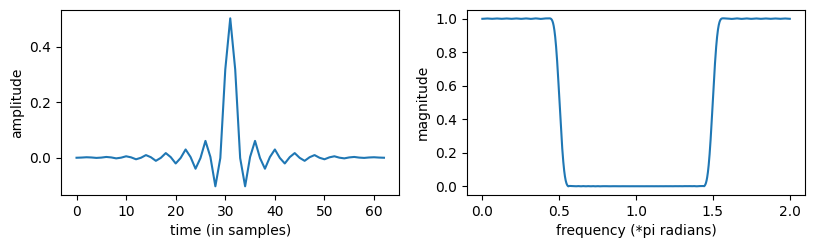

In [14]:
# lowpass 0.5, hamming window
H = np.array([1.0]*129 + [0.0]*128)   # 512 길이의 0-pi
NffDraw = 2048
for order in [2,6,14,30,62]:
    h = getFIRFFT(H, order, winname='hamming')
    plt.figure(figsize=FIG_SIZE*np.array([1.2,0.8]))
    drawFIRFFT(h, NFFT=2048)

> hamming window를 써야 부드러운 response 를 얻을 수 있다.

audio file 에 적용

In [15]:
# returns decibel, with preventing 0 input
# note: input should be X(w) or x[n]
# dB = 20 log_10 (abs(x)) = 10 log_10 ( x^2 ) 
def decibel_sq_safe(x, epsilon=1e-10):
    return 10*np.log10(np.maximum(np.real(x*np.conj(x)),epsilon))

def drawspectrogram2(x, Nf, Ns=None, winname='hamming', minpercentile=80, isdbscale=True, isdraw=True):
    # Short-time Fourier transform with half-overlap 
    # Nf: analysis size
    # Ns: shift size 
    # NFFT: FFT size, power of 2
    if Ns==None: Ns=Nf//2
    num_frames = (len(x)-Nf)//Ns+1  # 마지막 채워지지 않은 프레임은 버린다. 구현에 따라 zero-padding해서 사용 가능
    NFFT = int(2**(np.ceil(np.log2(Nf))))   # Nf보다 크거나 같은 2의 거듭제곱을 NFFT 로 정의
    hNo = NFFT//2+1
    X = np.zeros((hNo,num_frames))
    
    # generate window
    if winname=='rect' or winname=='rectangular':
        win = np.ones(Nf)
    else:   # hamming, hann, etc.
        win = librosa.filters.get_window(winname, Nf, fftbins=True)
        
    # STFT
    for i in range(num_frames):
        y = np.fft.fft(win*x[(i*Ns):(i*Ns+Nf)], n=NFFT)
        y = y[:hNo]
        if isdbscale: y = decibel_sq_safe(y)
        else: y = np.abs(y)
        X[:,i] = y

    if isdraw:
        # 상위 80% 정도만 scale 한다. imshow의 vmin vmax 이용 
        vmax = np.max(X[:])
        vmin = np.percentile(X[:], minpercentile)
        specgram_axis = [0,float(len(x))/float(Fs),0,float(Fs)/2]
        plt.imshow(X, cmap=cmap_plot, aspect='auto', origin='lower', extent=specgram_axis, vmax=vmax, vmin=vmin)
        plt.xlabel('time (seconds)')
        plt.ylabel('frequency (Hz)')
    
    return X

- wav file을 저장한다.

In [16]:
import scipy 
def writewav(filename, samplerate, data, maxval=1.0):
    data = data/maxval*(2**15)    # 16 bit
    scipy.io.wavfile.write(filename, samplerate, data.astype(np.int16))

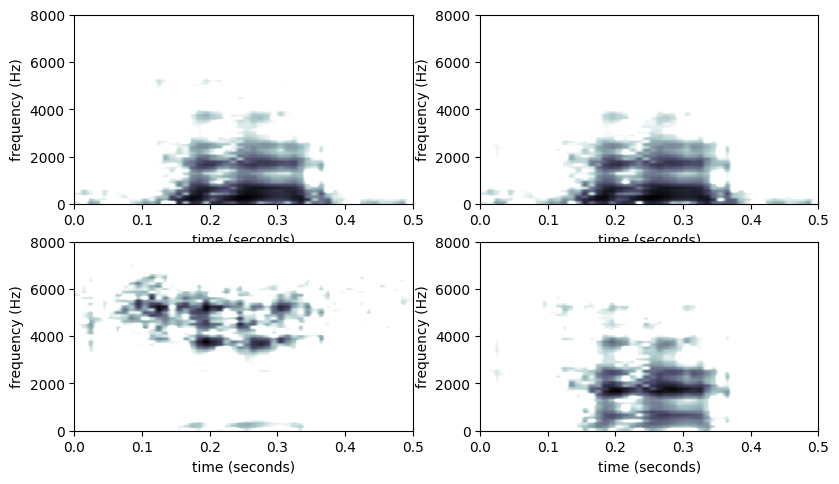

In [17]:
order = 14
plt.figure(figsize=FIG_SIZE*np.array([1.2,1.8]))

# original
plt.subplot(2,2,1)
X = drawspectrogram2(x, Nf, Ns, 'hamming')

# lowpass
H = [1.0]*(order//2) + [0.0]*(order//2)
h = getFIRFFT(np.array(H), order, winname='hamming')
x2 = signal.lfilter(h, [1], x)
plt.subplot(2,2,2)
X = drawspectrogram2(x2, Nf, Ns, 'hamming')

# save to a file
writewav('x2-lowpass.wav', Fs, x2)

# highpass
H = [0.0]*(order//2) + [1.0]*(order//2)
h = getFIRFFT(np.array(H), order, winname='hamming')
x2 = signal.lfilter(h, [1], x)
plt.subplot(2,2,3)
X = drawspectrogram2(x2, Nf, Ns, 'hamming')

# save to a file
writewav('x2-highpass.wav', Fs, x2)

# bandpass
H = [0.0]*(order//4) + [1.0]*(order-order//4*2) + [0.0]*(order//4)
h = getFIRFFT(np.array(H), order, winname='hamming')
x2 = signal.lfilter(h, [1], x)
plt.subplot(2,2,4)
X = drawspectrogram2(x2, Nf, Ns, 'hamming')

# save to a file
writewav('x2-bandpass.wav', Fs, x2)

- 저장된 소리를 들어본다.

In [18]:
#from playsound import playsound
#playsound(filename)
import IPython
#IPython.display.Audio(filename)

In [19]:
IPython.display.Audio(wavfile)

In [20]:
IPython.display.Audio('x2-lowpass.wav')

In [21]:
IPython.display.Audio('x2-highpass.wav')

In [22]:
IPython.display.Audio('x2-bandpass.wav')

---
## Short Time filtering with fixed filter, and FIR memory

지금까지는 모든 입력이 주어졌다고 가정하고 전체 신호에 대하여 필터링을 수행하였다. 하지만 실제 시스템에서는 입력이 온라인으로 실시간으로 주어진다.
따라서 이러한 경우를 고려하여 short-time filtering 을 수행한다.
- 매 10ms 마다 lowpass filtering 을 해 본다.
- fixed (constant) lowpass filter design

- 실험을 위하여 다음과 같이 1/2/3/4 kHz ($\frac{1}{\pi}, \frac{2}{\pi}, \frac{3}{\pi}, \frac{4}{\pi}$) 성분을 가지는 신호를 생성한다.
- drawspectrum 을 위한 frame length, shift length 는 좀더 촘촘하게 한다. (Nf = 320->160, Ns = 160->40)

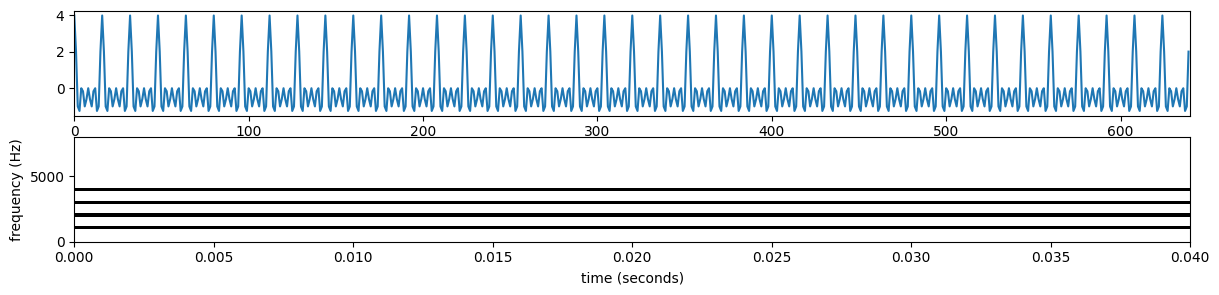

In [23]:
# 길이는 40ms
N = Ns*4

# spectrogram 을 그릴 때 좀더 촘촘히 본다.
Nf2, Ns2 = Nf//2, Ns//4

# 1kHz 간격 각속도 
w1khz = Fs/2/1000

# cosine 생성, 주파수 1/2/3/4 kHz 의 합으로 생성
sinusoid = np.zeros(N)
wticks = np.arange(N)/NFFT*(2*np.pi)*4
sinusoid += np.cos(wticks*w1khz*1)
sinusoid += np.cos(wticks*w1khz*2)
sinusoid += np.cos(wticks*w1khz*3)
sinusoid += np.cos(wticks*w1khz*4)

plt.figure(figsize=FIG_SIZE*np.array([1.8,1.0]))
plt.subplot(2,1,1)
plt.plot(sinusoid)
plt.xlim([0, len(sinusoid)])
plt.subplot(2,1,2)
X = drawspectrogram2(sinusoid, Nf2, Ns2, 'hamming')

- cutoff frequency 1.1kHz 인 lowpass filter  정의 

array([-0.00027336, -0.0011086 , -0.00244128, -0.00439212, -0.00657366,
       -0.00798904, -0.00715057, -0.00241863,  0.00751457,  0.02313036,
        0.04373225,  0.06736429,  0.09105676,  0.11136458,  0.125077  ,
        0.12992126,  0.125077  ,  0.11136458,  0.09105676,  0.06736429,
        0.04373225,  0.02313036,  0.00751457, -0.00241863, -0.00715057,
       -0.00798904, -0.00657366, -0.00439212, -0.00244128, -0.0011086 ,
       -0.00027336])

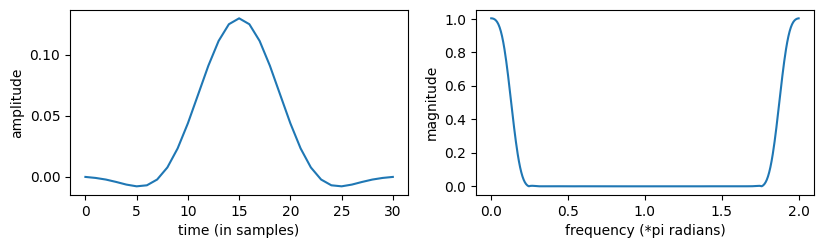

In [24]:
# lowpass 1.1/8, hamming window
order = 30
n = int((1100 / (Fs/2))*(Nf+1))
#print(n)
H = np.array([1.0]*n + [0.0]*(Nf-n))   # 101 길이의 0-pi

h = getFIRFFT(H, order, winname='hamming')
plt.figure(figsize=FIG_SIZE*np.array([1.2,0.8]))
drawFIRFFT(h, NFFT=NFFT)

- lowpass filtering 을 하면 다음과 같이 상위 주파수 cosine 이 없어진다.
    - 1.1 kHz 신호만 남는다
    - 시작 프레임에서는 앞부분에서 왜곡이 발생하여 주파수 영역에서 pure sinusoid 가 아닌 성분들이 보여진다. (why?)

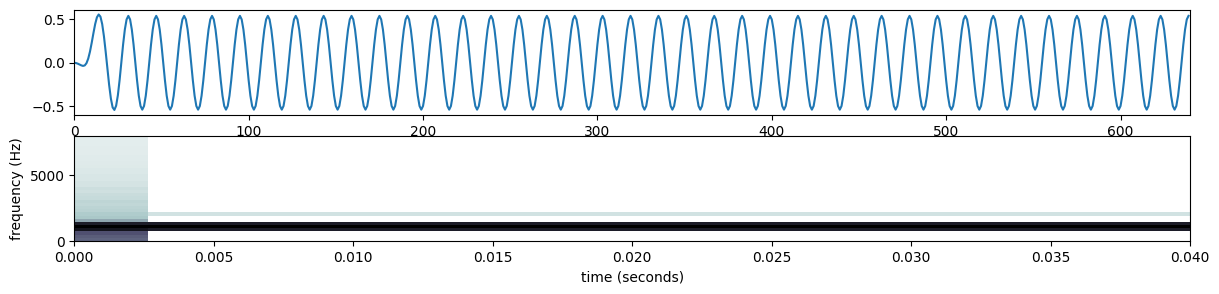

In [25]:
y = signal.lfilter(h, [1], sinusoid)
plt.figure(figsize=FIG_SIZE*np.array([1.8,1.0]))
plt.subplot(2,1,1)
plt.plot(y)
plt.xlim([0, len(y)])
plt.subplot(2,1,2)
X = drawspectrogram2(y, Nf2, Ns2, 'hamming')

__short time processing for online input__
- 신호를 10ms 단위로 나누고 filtering 한다.
- overlap은 없다. 
- 출력 신호에서 frame이 바뀌는 시점에서(160 단위) 왜곡이 발생한다. 
    - FIR filtering의 처음 order 만큼의 출력에서 이전 sample 값들이 0으로 되기 때문
    - offline filtering 결과($y$)와의 오류를 계산한다.
    $$ err = \sqrt{ E[(y_{short}-y)^2] } = \sqrt{ \frac{1}{N} \sum_{n=1}^{N} E[(y_{short}[n]-y[n])^2 }$$
    - SNR (signal-to-noise ratio)는 원신호($y$) 대 잡음(err)의 비로 정의되며 dB scale 로 주로 계산한다.
    $$ SNR = 10 \log_{10} \frac{E[y^2]}{err^2} = 10 \log_{10} \frac{\frac{1}{N} \sum_{n=1}^{N} y^2}{ \frac{1}{N} \sum_{n=1}^{N} (y_{short}-y)^2} \, (dB) $$

error = 0.09817,  snr = 11.72 dB


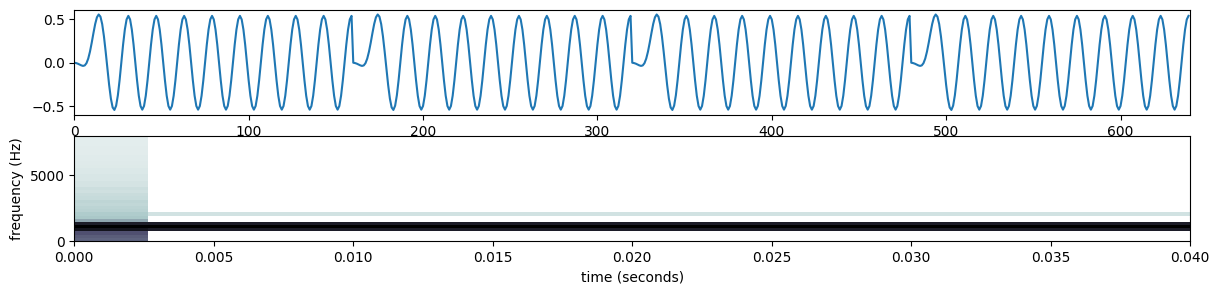

In [26]:
y2 = np.zeros_like(sinusoid)
order = len(h)-1
for t in range(Ns,len(sinusoid)+1,Ns):
    x = sinusoid[(t-Ns):t]
    y2[(t-Ns):t] = signal.lfilter(h, [1], x)

# offline filtering 결과와의 오류를 계산한다 
y = signal.lfilter(h, [1], sinusoid)
err = np.sqrt(np.mean((y2-y)**2))
snr = 10*np.log10(np.mean(y**2)/err**2)
print('error = %.5f,  snr = %.2f dB' % (err, snr))
    
plt.figure(figsize=FIG_SIZE*np.array([1.8,1.0]))
plt.subplot(2,1,1)
plt.plot(y2)
plt.xlim([0, len(y2)])
plt.subplot(2,1,2)
X = drawspectrogram2(y, Nf2, Ns2, 'hamming')

- frame 이 만나는 부분에서 왜곡이 발생하고 주파수 축에서 넓게 퍼지게 보임 
    - offline processing 에서 첫번째 frame 에서만 발생한 것이 frame이 만나는 부분에서 발생함
- 이 문제를 해결하기 위해서는 memory 필요 
- 처음의 order 수 만큼의 sample 은 이전 frame 의 sample 이 필요함. 이를 memory (buffer)에 저장하여 전달함.

![FIR filtering with memory](figures/lab03_fir-mem.png)

error = 0.00000,  snr = 332.43 dB


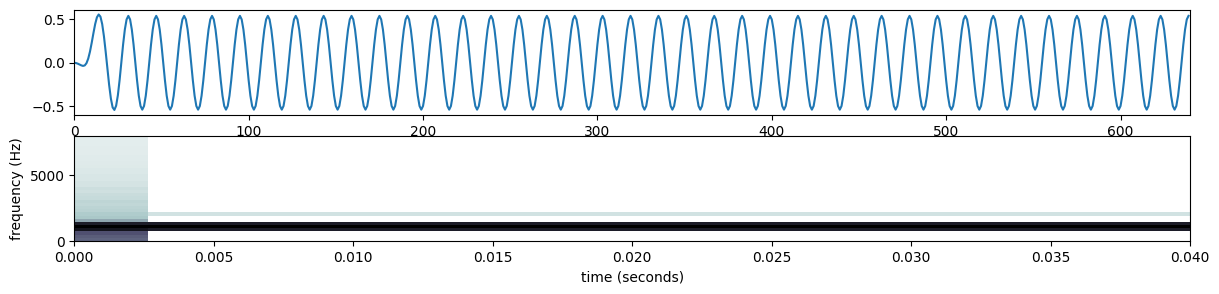

In [27]:
# with memory, short-time processing, 10ms, no overlap
y3 = np.zeros_like(sinusoid)
order = len(h)-1
xmem = np.zeros(order)
for t in range(Ns,len(sinusoid)+1,Ns):
    x = sinusoid[(t-Ns):t]
    #y2[(t-Ns):t] = signal.lfilter(h, [1], x)
    
    # filtering with memory
    x = np.concatenate((xmem, x))
    yt = signal.lfilter(h, [1], x)
    y2[(t-Ns):t] = yt[order:]
    xmem[:] = x[-order:]
    
    # 다음의 방법으로도 가능하다.(lfilter에서 제공하는 방법)
    '''
    yt, ymem = signal.lfilter(h, [1], x, zi=xmem)
    y2[(t-Ns):t] = yt[order:]
    xmem[:] = x[-order:]
    '''

# offline filtering 결과와의 오류를 계산한다 
y = signal.lfilter(h, [1], sinusoid)
err = np.sqrt(np.mean((y2-y)**2))
snr = 10*np.log10(np.mean(y**2)/err**2)
print('error = %.5f,  snr = %.2f dB' % (err, snr))
    
plt.figure(figsize=FIG_SIZE*np.array([1.8,1.0]))
plt.subplot(2,1,1)
plt.plot(y2)
plt.xlim([0, len(y2)])
plt.subplot(2,1,2)
X = drawspectrogram2(y, Nf2, Ns2, 'hamming')

- 오류가 크게 줄었다. ($ \textrm{SNR} < 300 \textrm{ dB}$, 실질적으로는 없음)
- 함수로 만들어서 이후에 사용한다.

In [28]:
def lfirfiltermem(h, x, xmem=[]):
    order = len(h)-1
    if len(xmem)==0: xmem = np.zeros(order)    
    y = signal.lfilter(h, [1], np.concatenate((xmem, x)))
    xmem[:] = x[-order:]
    return y[order:], xmem

# Challenge: 함수 lfilter를 사용하지 않고 for loop 만을 이용하여 구현해 본다.
# 훨씬더 효율적으로 작성 가능하다.

---
## Programming assignments: Short Time Fourier transform with filtering

- 위의 `getFIRFFT` 함수를 보지 않고 작성해 본다.
- cutoff frequency 가 linear하게 올라가는 lowpass filter에 대해서 10ms shift, 3ms overlap의 trapezoidal (사다리꼴 overlap-add) 구현

.

---
## (SOLUTION) Short Time filtering with varying filter, FIR memory, and overlap-add

- 실험을 위하여 다음과 같이 1/2/3/4 kHz ($\frac{1}{\pi}, \frac{2}{\pi}, \frac{3}{\pi}, \frac{4}{\pi}$) 성분을 가지는 신호를 생성한다. (이전 예제와 같음)

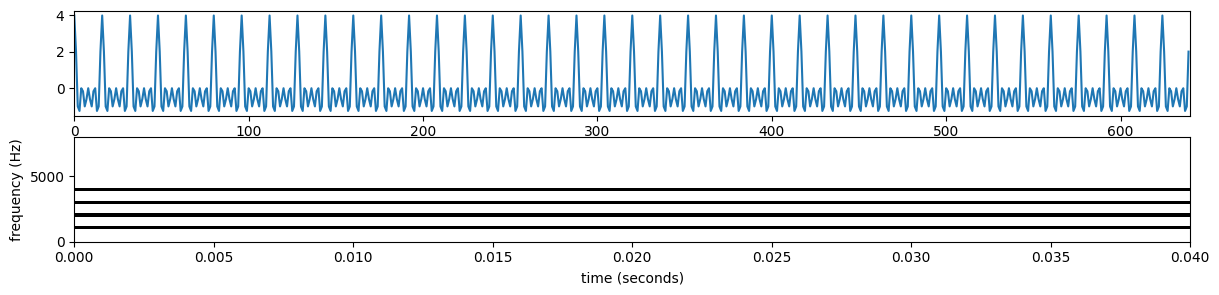

In [29]:
# 길이는 40ms
N = Ns*4

# 1kHz 간격 각속도 
w1khz = Fs/2/1000

# cosine 생성, 주파수 1/2/3/4 kHz 의 합으로 생성
sinusoid = np.zeros(N)
wticks = np.arange(N)/NFFT*(2*np.pi)*4
#for (a,b) in [(1,1), (2,7), (3,11), (4,17)]:
for (a,b) in [(1,0), (2,0), (3,0), (4,0)]:
    sinusoid += np.cos(wticks*w1khz*a+b)

plt.figure(figsize=FIG_SIZE*np.array([1.8,1.0]))
plt.subplot(2,1,1)
plt.plot(sinusoid)
plt.xlim([0, len(sinusoid)])
plt.subplot(2,1,2)
X = drawspectrogram2(sinusoid, Nf2, Ns2, 'hamming')

매 10ms 마다 중심 주파수가 다른 bandpass filter 들를 생성한다. 
- 인위적으로 네 개의 주파수 1/2/3/4 kHz ($\frac{1}{\pi}, \frac{2}{\pi}, \frac{3}{\pi}, \frac{4}{\pi}$) 를 중심으로 생성함
- 순서는 섞었다.

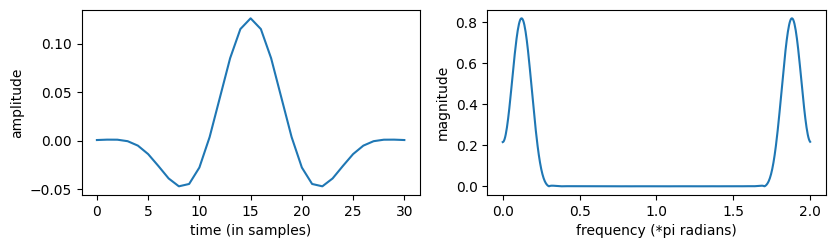

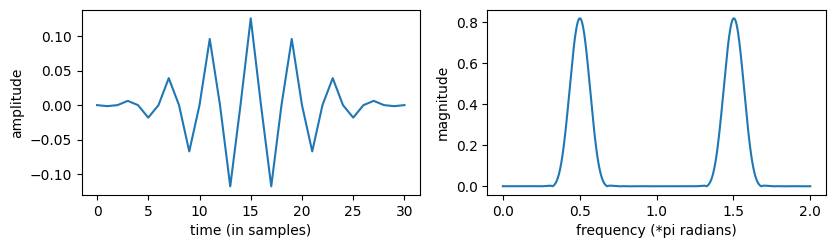

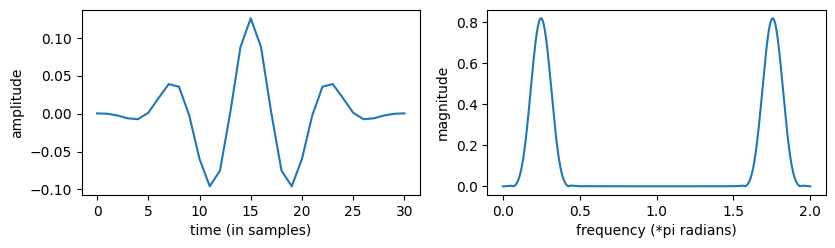

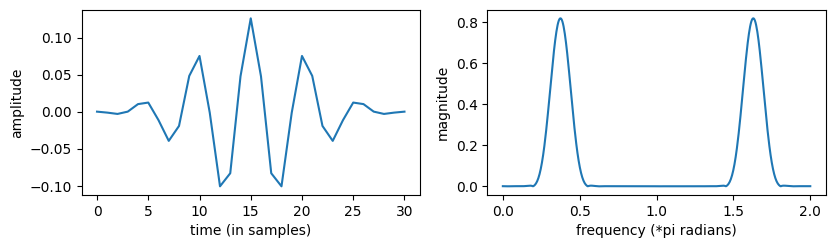

In [30]:
# bandpass filters with bandwidth 1.0 kHz, 
# center frequency 1,2,3,4 kHz
order = 30
h_a = []
bandwidth = 1000
# frame 경계에서 불연속성을 잘 보이기 위해서 인위적으로 위치를 바꿈 
for f in [1000, 4000, 2000, 3000]:
    n1 = int(((f-bandwidth//2) / (Fs/2))*(Nf+1))
    n1 = max(0,n1)
    n2 = int(((f+bandwidth//2) / (Fs/2))*(Nf+1))
    n2 = min(Nf,n2)
    #print(n1,n2)
    H = np.zeros(Nf)
    H[n1:n2] = 1.0
    h = getFIRFFT(H, order, winname='hamming')
    h_a.append(h)
    
    plt.figure(figsize=FIG_SIZE*np.array([1.2,0.8]))
    drawFIRFFT(h, NFFT=NFFT)

__short time processing__
- 필터가 매 10ms 마다 변한다고 가정하고 short time processing을 실시한다.
- 위에서 정의한 memory fir filter를 사용한다.

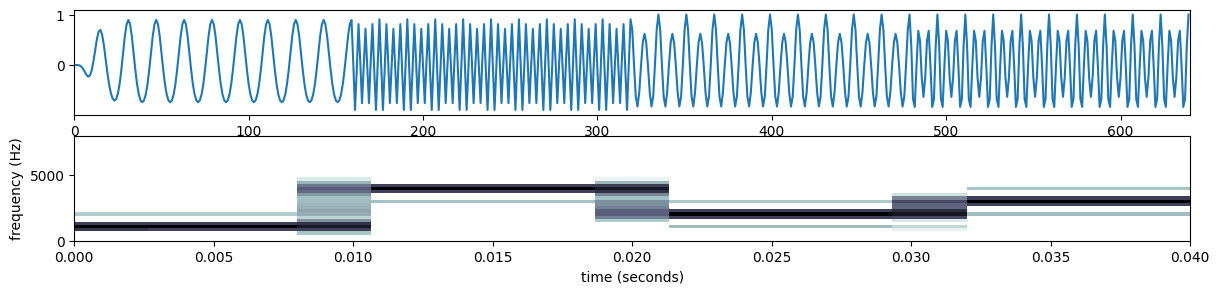

In [31]:
# short-time processing, 10ms, with memory, time-varying filter, no overlap
y3 = np.zeros_like(sinusoid)
order = len(h_a[0])-1
xmem = np.zeros(order)
for n in range(len(h_a)):
    # filtering with memory 
    x = sinusoid[(n*Ns):((n+1)*Ns)]
    
    # filtering with memory
    #y3[(n*Ns):((n+1)*Ns)], xmem = lfirfiltermem(h_a[n], x, xmem)
    x = np.concatenate((xmem, x))
    yt = signal.lfilter(h_a[n], [1], x)
    y3[(n*Ns):((n+1)*Ns)] = yt[order:]
    xmem[:] = x[-order:]

plt.figure(figsize=FIG_SIZE*np.array([1.8,1.0]))
plt.subplot(2,1,1)
plt.plot(y3)
plt.xlim([0, len(y3)])
plt.subplot(2,1,2)
X = drawspectrogram2(y3, Nf2, Ns2, 'hamming')

In [32]:
# 들어보기 위해서 좀더 길게 생성한다.
def longcosine(a):
    N = Ns*4*a

    # 1kHz 간격 각속도 
    w1khz = Fs/2/1000

    # cosine 생성, 주파수 1/2/3/4 kHz 의 합으로 생성
    sinusoid = np.zeros(N)
    wticks = np.arange(N)/NFFT*(2*np.pi)*4
    #for (a,b) in [(1,1), (2,7), (3,11), (4,17)]:
    for (a,b) in [(1,0), (2,0), (3,0), (4,0)]:
        sinusoid += np.cos(wticks*w1khz*a+b)
    return sinusoid

# Fs 를 1/4로 낮춰 듣기 편하게 만든다
writewav('sinusoid.wav', Fs//4, longcosine(20))
IPython.display.Audio('sinusoid.wav')

In [33]:
def longfiltering(a):
    X = longcosine(a)
    y = np.zeros_like(X)
    order = len(h_a[0])-1
    long_h_a = []
    for n in range(len(h_a)): long_h_a.extend([h_a[n]]*a)
    xmem = np.zeros(order)
    for n in range(len(X)//Ns):
        x = np.concatenate((xmem, X[(n*Ns):((n+1)*Ns)]))
        yt = signal.lfilter(long_h_a[n], [1], x)
        y[(n*Ns):((n+1)*Ns)] = yt[order:]
        xmem[:] = x[-order:]
    return y

# Fs 를 1/4로 낮춰 듣기 편하게 만든다
ylong = longfiltering(20)
writewav('sinusoid_filtered.wav', Fs//4, ylong)
IPython.display.Audio('sinusoid_filtered.wav')

- 시간축에서 filter가 변하는 160, 320, 280 에서 불연속 경계가 발생한다. 
- 불연속성에 의해 주파수 축에서도 주변에서 변화가 생긴다. 
- overlap-add 를 이용하여 연결되는 부분에서 부드럽게 이어지도록 붙인다. 
    - shift size 10ms, overlap size 3ms의 사다리꼴(trapezoidal window) 사용
    - delay 3ms 발생, buffer size = 3ms + filter order (tab - 1)
    - (대안) frame size 20ms, shift 10ms, overlap 10ms, hanning window 를 사용할 수도 있지만 그러면 전체 delay 가 너무 커지기 때문에 online processing 에는 적합하지 않음

![FIR filtering with memory](figures/lab03_ola.png)

memory size (order = M) = (30,) samples
overlap size (3.0 ms) = (48,) samples
LeftWinOverlap  size = (48,) samples
RightWinOverlap size = (48,) samples
[0.02040816 0.04081633 0.06122449 0.08163265 0.10204082 0.12244898
 0.14285714 0.16326531 0.18367347 0.20408163 0.2244898  0.24489796
 0.26530612 0.28571429 0.30612245 0.32653061 0.34693878 0.36734694
 0.3877551  0.40816327 0.42857143 0.44897959 0.46938776 0.48979592
 0.51020408 0.53061224 0.55102041 0.57142857 0.59183673 0.6122449
 0.63265306 0.65306122 0.67346939 0.69387755 0.71428571 0.73469388
 0.75510204 0.7755102  0.79591837 0.81632653 0.83673469 0.85714286
 0.87755102 0.89795918 0.91836735 0.93877551 0.95918367 0.97959184]
[0.97959184 0.95918367 0.93877551 0.91836735 0.89795918 0.87755102
 0.85714286 0.83673469 0.81632653 0.79591837 0.7755102  0.75510204
 0.73469388 0.71428571 0.69387755 0.67346939 0.65306122 0.63265306
 0.6122449  0.59183673 0.57142857 0.55102041 0.53061224 0.51020408
 0.48979592 0.46938776 0.44897959 0.42857143

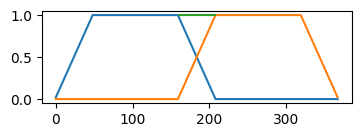

In [34]:
# memory M (order) samples
order = len(h_a[0])-1
xmem = np.zeros(order)

# overlap 3ms
Tov = 0.003  # 3 miliseconds
Nov = int(Fs*Tov)
xoverlap = np.zeros(Nov)

# short-time processing, 10ms, with memory, time-varying filter, no overlap
#y4 = np.zeros_like(sinusoid)
y4 = np.zeros(len(sinusoid)+Nov)   # delay T_overlap (N_overlap)
yt = np.zeros(Ns+Nov)
RightWinOverlap = np.linspace(1,0,Nov+2)[1:-1]
LeftWinOverlap = np.linspace(0,1,Nov+2)[1:-1]

######################################################################
# test: make sure Left+Right = 1 in the overlap area
print('memory size (order = M) =', xmem.shape,  'samples')
print('overlap size (%.1f ms) =' % (Tov*1000), xoverlap.shape,  'samples')
print('LeftWinOverlap  size =', LeftWinOverlap.shape,  'samples')
print('RightWinOverlap size =', RightWinOverlap.shape, 'samples')
print(LeftWinOverlap)
print(RightWinOverlap)
frameKm1 = np.concatenate((LeftWinOverlap, np.ones(Ns-Nov), RightWinOverlap, np.zeros(Ns)))
frameK = np.concatenate((np.zeros(Ns),LeftWinOverlap, np.ones(Ns-Nov), RightWinOverlap))
plt.figure(figsize=FIG_SIZE*np.array([0.5,0.4]))
plt.plot(frameKm1)
plt.plot(frameK)
plt.plot(np.arange(Ns,Ns+Nov),LeftWinOverlap+RightWinOverlap)
#####################################################################

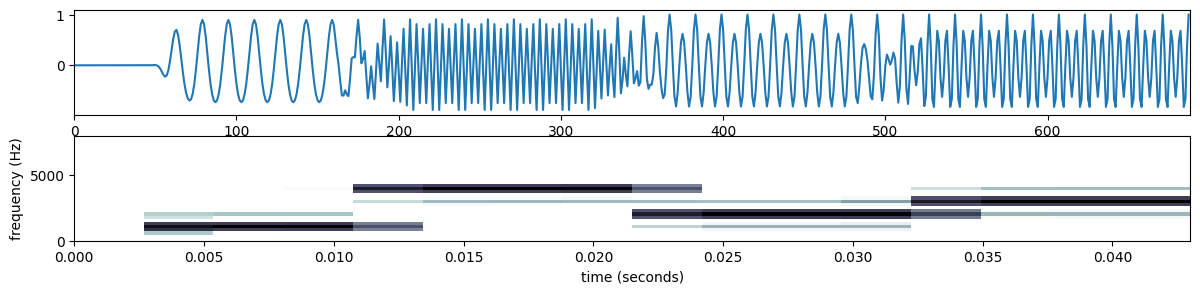

In [35]:
# short-time processing, 10ms, with memory, time-varying filter, no overlap
#y4 = np.zeros_like(sinusoid)
y4 = np.zeros(len(sinusoid)+Nov)   # delay T_overlap (N_overlap)
yt = np.zeros(Ns+Nov)

for n in range(len(h_a)):
    # 1. add last y_overlap
    y4[(n*Ns):(n*Ns+Nov)] = yt[Ns:] * RightWinOverlap
    
    # 2. input
    x = sinusoid[(n*Ns):((n+1)*Ns)]

    # 3. filtering with memory
    x = np.concatenate((xmem, xoverlap, x))
    yt[:] = signal.lfilter(h_a[n], [1], x)[order:(order+Nov+Ns)]
    
    # 4. overlap add
    y4[(n*Ns):(n*Ns+Nov)] += yt[:Nov] * LeftWinOverlap
    y4[(n*Ns+Nov):((n+1)*Ns)] = yt[Nov:Ns]

    # 5. memory update
    xmem[:] = x[Ns:(order+Ns)]
    xoverlap[:] = x[(order+Ns):(order+Nov+Ns)]

# store last remaining y_overlap
y4[(len(h_a)*Ns):] = yt[Ns:]


######################################################################
# test: smoothed transition
plt.figure(figsize=FIG_SIZE*np.array([1.8,1.0]))
plt.subplot(2,1,1)
plt.plot(y4)
plt.xlim([0, len(y4)])
plt.subplot(2,1,2)
X = drawspectrogram2(y4, Nf2, Ns2, 'hamming')
######################################################################

이와같이 overlap add 를 하는 것은 매우 복잡하다. 따라서 추후에 쉽게 사용하기 위하여 다음과 같이 `class` 로 작성한다.

### class FIR Overlap Add

- Linear phase FIR filter를 구하는 함수를 재정의한다. 

In [36]:
#######################################################
# re-definition of getFIRFFT to 
# 1. make sure that it generates linear phase (symmetric real) filter
# 2. be renamed to indiate the above
# 3. return the linear phase filter and the delay incurred by the filtering
def getLPHFIRFFT(H, order, winname=None):
    # H: NFFT/2+1
    NFFT = (len(H)-1)*2
    H = np.concatenate((H, H[-2:0:-1])) + np.zeros(NFFT)*(1j)
    h = np.fft.ifft(H, NFFT)
    
    # adjust order if necessary
    order = min(NFFT-1, order)  # at most NFFT samples
    delay = order//2     # delay by the filtering is half the order
    order = delay*2      # odd order -> even so that the filter is symmetric w.r.t. the center sample
    
    #h = np.concatenate((h[len(h)//2:], h[0:len(h)//2]))
    h = np.concatenate((h[(len(h)-delay):], h[0:delay+1]))
    if winname != None:
        win = librosa.filters.get_window(winname, order+1, fftbins=False)
        h = h*win
    return h.real, delay

매 10ms 마다 중심 주파수가 다른 bandpass filter 들를 생성한다. 
- 인위적으로 네 개의 주파수 1/2/3/4 kHz ($\frac{1}{\pi}, \frac{2}{\pi}, \frac{3}{\pi}, \frac{4}{\pi}$) 를 중심으로 생성함
- 순서는 섞었다.
- delay buffer 출력을 얻기 위해 마지막에 dummy filter (마지막 것과 동일)을 추가하였다. 

In [37]:
# generate bandpass filters with bandwidth 1.0 kHz, 
# center frequency 1,2,3,4 kHz
order = 30
h_a = []
bandwidth = 1000
# frame 경계에서 불연속성을 잘 보이기 위해서 인위적으로 위치를 바꿈 
for f in [1000, 4000, 2000, 3000]:
    n1 = max(0,int(((f-bandwidth//2) / (Fs/2))*(Nf+1)))
    n2 = min(Nf,int(((f+bandwidth//2) / (Fs/2))*(Nf+1)))
    H = np.zeros(Nf)
    H[n1:n2] = 1.0
    h, delay = getLPHFIRFFT(H, order, winname='hamming')
    #print('filter length = %d, delay = %d' % (len(h), delay))
    h_a.append(h)

# last identity filter to clean up the last buffer
h_a.append(h_a[-1])
h_a.append(h_a[-1])
#h_a.append(np.ones(1))
#h_a.append(np.ones(1))
#h_a.append([])
#h_a.append([])

- `class` 로 FIR overlap add 를 구현함 

In [38]:
######################################################################
# class definition for trapezoidal FIR filter overlap-add
class firoverlapadd:
    def __init__(self):
        self.initializeAllVar()

    def initializeAllVar(self):
        # initially, all empty
        self.Ns = 0
        self.Nov = 0
        self.M = 0
        self.FIRshift = 0
        self.rwin = np.zeros(0)
        self.lwin = np.zeros(0)
        self.lastNx = 0   # length of last x input
        self.lastNy = 0   # length of last y output
        self.xbuf = np.zeros(0)
        self.ybuf = np.zeros(0)
        self.yout = np.zeros(0)

    # set the parameters using number of samples
    # Ns, Nov: do not change when the given values are less than or equal to 0
    # order, FIRshift: do not change when the given values are less than 0 (0 is valid)
    def set(self, Ns=0, Nov=0, order=-1, FIRshift=-1):
        if Ns>0: self.Ns = Ns
        if Nov>0: self.Nov = Nov
        if order>=0: self.M = order
        if FIRshift>=0: self.FIRshift = FIRshift
        self.allocBuffer()

    # find order and FIRshift from the linear phase filter
    def setbyLPHFIRtab(self, ntab, Ns=0, Nov=0):
        self.set(Ns, Nov, self.getOrderByFilter(ntab), self.getLinearPhaseDelay(ntab))

    # set the order by an FIR filter
    def getOrderByFilter(self, ntab): 
        return ntab-1
    # set the FIR shift by a linear phase FIR filter
    def getLinearPhaseDelay(self, ntab):
        return (ntab-1)//2
    # delay of the output
    def getDelay(self): 
        return self.Nov+self.FIRshift
        #return self.Nov

    # allocate memory and buffers, assuming that the numbers are already set properly
    def allocBuffer(self):
        self.rwin = np.linspace(1,0,self.Nov+2)[1:-1]
        self.lwin = np.linspace(0,1,self.Nov+2)[1:-1]
        self.xbuf = np.zeros(self.M+self.Nov+self.Ns)
        self.ybuf = np.zeros(self.M+self.Nov+self.Ns)
        self.yout = np.zeros(self.Ns)
        self.lastNx = 0
        self.lastNy = self.getDelay()

    # clear all the memory and buffers
    def resetBuffer(self):
        self.xbuf[:] = 0
        self.ybuf[:] = 0
        self.yout[:] = 0
        self.lastNx = 0
        self.lastNy = self.getDelay()

    # single frame processing
    def doFilterMem(self, h, x):
        ############################################
        # elaborate input x
        # x-1. shift buffer
        for ii in range(self.M+self.Nov):
            self.xbuf[ii] = self.xbuf[ii+self.Ns]
            
        # x-2. copy the new input
        self.lastNx = len(x)
        if len(x) > 0:
            for ii in range(self.Ns):
                self.xbuf[ii+self.M+self.Nov] = x[ii]
        else:   # no input, clear buffer
            self.xbuf[(self.M+self.Nov):] = np.zeros(self.Ns)

        ############################################
        # generate output y
        # y-1. copy the overlapped old output, overlapped
        self.yout[:self.Nov] = self.ybuf[(-self.Nov):]
        
        # y-2. do filtering (if necessary)
        if len(h) > 1: 
            # if do assignment as follows, exception unless 
            # the lengths of left and right match (to prevent bug)
            self.ybuf[:] = signal.lfilter(h, [1], self.xbuf)
        elif len(h) == 1:  # simple amplifier
            self.ybuf[:] = h[0]*self.xbuf[:]
        else:   # no filter at all
            self.ybuf[:] = np.zeros(self.M+self.Nov+self.Ns)
        
        # y-3. multiply trapezoidal window
        self.ybuf[self.M:(self.M+self.Nov)] *= self.lwin
        self.ybuf[(-self.Nov):] *= self.rwin
        
        # y-4. overlap-add
        self.yout[:self.Nov] += self.ybuf[self.M:(self.M+self.Nov)]
        self.yout[self.Nov:self.Ns] = self.ybuf[(self.M+self.Nov):(self.M+self.Ns)]

        '''
        plt.figure(figsize=FIG_SIZE*np.array([1.8,0.5]))
        plt.subplot(2,1,1)
        plt.plot(self.ybuf[self.M:])
        plt.subplot(2,1,2)
        plt.plot(self.yout)
        '''
        
        # y-5. update output buffer length
        self.lastNy = self.lastNy + self.lastNx
        len_out = min(self.lastNy, self.Ns)
        #print('lastNx = %d, lastNy = %d, Ns = %d, len_out = %d' % (self.lastNx, self.lastNy, self.Ns, len_out))
        self.lastNy -= len_out

        # output and actual length
        return self.yout, len_out
    
    # all audio signal processing
    def doFilterAll(self, H, X):
        y = np.zeros(0)   # start from empty signal
        Ly, Lx, n = 0, len(X), 0
        while True:
            # 1. input
            t1,t2 = min(Lx,n*self.Ns),min(Lx,(n+1)*self.Ns)
            x = X[t1:t2]

            # 2. filtering with memory and overlap add
            if n >= len(H): h = []
            else: h = H[n]
            [yt,Lyt] = self.doFilterMem(h, x)

            # 3. process one frame and append it
            if Lyt > 0:
                Ly += Lyt
                y = np.concatenate((y, yt[:Lyt]))
            else: break
            n+=1
        return y

- 내부 함수 사용 예제 

In [39]:
'''
# create an instance of class firoverlapadd
# shift 10ms, overlap 3ms
fola = firoverlapadd()
fola.setbyLPHFIRtab(len(h_a[0]), int(Fs*0.010), int(Fs*0.003))
y = fola.doFilterAll(h_a, sinusoid)
# y is the online output stream (with delay 3ms)
'''

'\n# create an instance of class firoverlapadd\n# shift 10ms, overlap 3ms\nfola = firoverlapadd()\nfola.setbyLPHFIRtab(len(h_a[0]), int(Fs*0.010), int(Fs*0.003))\ny = fola.doFilterAll(h_a, sinusoid)\n# y is the online output stream (with delay 3ms)\n'

- 외부에서 하나씩 frame 을 입력하여 출력을 받는다. 
- empty 입력을 주면 buffer만으로 생성한 출력을 받을 수 있다.

In [40]:
# create an instance of class firoverlapadd
# shift 10ms, overlap 3ms
fola = firoverlapadd()
fola.setbyLPHFIRtab(len(h_a[0]), int(Fs*0.010), int(Fs*0.003))

# short-time processing, 10ms, with memory, time-varying filter, no overlap
y = np.zeros(0)   # start from empty signal
Ly = 0

n = 0
Lx = len(sinusoid)
while True:
    # 1. input
    t1,t2 = min(Lx,n*Ns),min(Lx,(n+1)*Ns)
    x = sinusoid[t1:t2]

    # 2. filtering with memory and overlap add
    [yt,Lyt] = fola.doFilterMem(h_a[n], x)
    print('n=%d, len(h_a)=%d len(x)=%d'%(n,len(h_a),len(x)))
    
    # 3. process one frame and append it
    if Lyt > 0:
        Ly += Lyt
        y = np.concatenate((y, yt[:Lyt]))
        '''
        plt.figure(figsize=FIG_SIZE*np.array([1.8,0.5]))
        plt.plot(y)
        print(y.shape)
        '''
        print('len(x)=%d, len(y)=%d' % (len(x), Lyt))
    else: 
        break
    
    n+=1

# y is the online output stream (with delay 3ms)

n=0, len(h_a)=6 len(x)=160
len(x)=160, len(y)=160
n=1, len(h_a)=6 len(x)=160
len(x)=160, len(y)=160
n=2, len(h_a)=6 len(x)=160
len(x)=160, len(y)=160
n=3, len(h_a)=6 len(x)=160
len(x)=160, len(y)=160
n=4, len(h_a)=6 len(x)=0
len(x)=0, len(y)=63
n=5, len(h_a)=6 len(x)=0


len(x) = 640, len(y) = 703, delay = 63
len(x) = 640, len(y) = 640, delay = 63


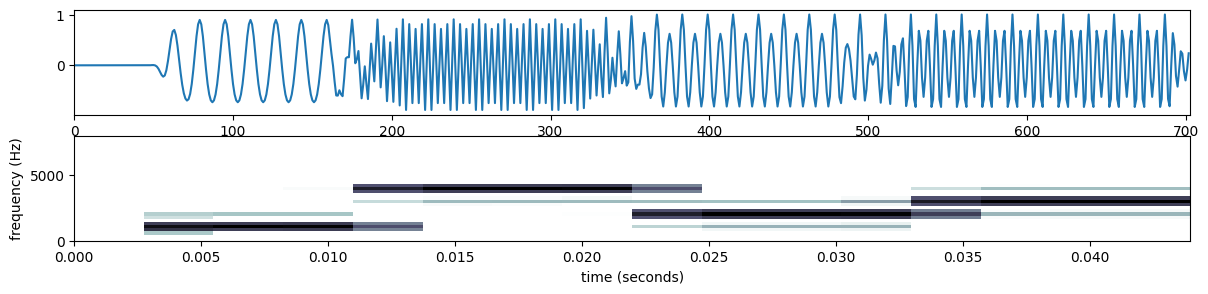

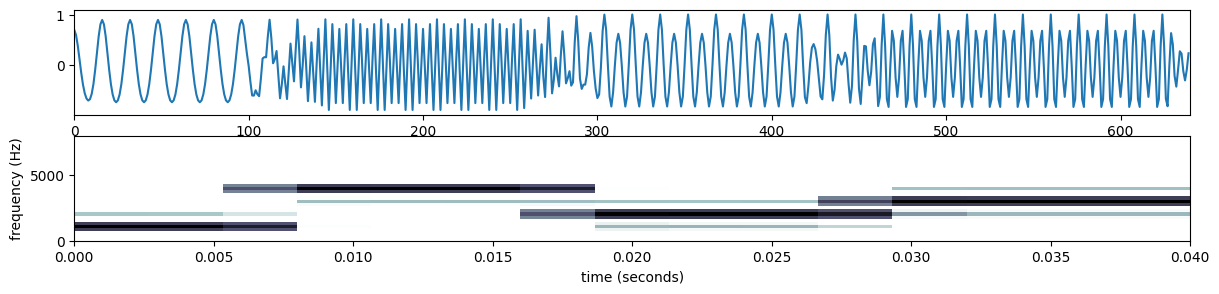

In [41]:
'''
######################################################################
# test: make sure Left+Right = 1 in the overlap area
print('xbuf size =', fola.xbuf.shape,  'samples')
print('ybuf size =', fola.ybuf.shape,  'samples')
print('yout size =', fola.yout.shape,  'samples')
print('LeftWinOverlap  size =', fola.lwin.shape,  'samples')
print('RightWinOverlap size =', fola.rwin.shape, 'samples')
print(fola.lwin)
print(fola.lwin)
frameKm1 = np.concatenate((fola.lwin, np.ones(Ns-Nov), fola.rwin, np.zeros(Ns)))
frameK = np.concatenate((np.zeros(Ns),fola.lwin, np.ones(Ns-Nov), fola.rwin))
plt.figure(figsize=FIG_SIZE*np.array([0.5,0.4]))
plt.plot(frameKm1)
plt.plot(frameK)
plt.plot(np.arange(Ns,Ns+Nov),fola.lwin+fola.rwin)
#####################################################################
'''

######################################################################
# test: smoothed transition
plt.figure(figsize=FIG_SIZE*np.array([1.8,1.0]))
plt.subplot(2,1,1)
plt.plot(y)
plt.xlim([0, len(y)])
plt.subplot(2,1,2)
X = drawspectrogram2(y, Nf2, Ns2, 'hamming')
print('len(x) = %d, len(y) = %d, delay = %d' % (len(sinusoid), len(y), fola.getDelay()))
######################################################################

######################################################################
# delayed signal
y = y[fola.getDelay():]
plt.figure(figsize=FIG_SIZE*np.array([1.8,1.0]))
plt.subplot(2,1,1)
plt.plot(y)
plt.xlim([0, len(y)])
plt.subplot(2,1,2)
X = drawspectrogram2(y, Nf2, Ns2, 'hamming')
print('len(x) = %d, len(y) = %d, delay = %d' % (len(sinusoid), len(y), fola.getDelay()))
######################################################################

In [42]:
def longfiltering(a):
    X = longcosine(a)
    long_h_a = []
    for n in range(len(h_a)): long_h_a.extend([h_a[n]]*a)

    fola = firoverlapadd()
    fola.setbyLPHFIRtab(len(long_h_a[0]), int(Fs*0.010), int(Fs*0.003))
    return fola.doFilterAll(long_h_a, X)
    

# Fs 를 1/4로 낮춰 듣기 편하게 만든다
ylong = longfiltering(20)
writewav('sinusoid_filtered_ola.wav', Fs//4, ylong)
IPython.display.Audio('sinusoid_filtered_ola.wav')

In [43]:
# non-overlap add 와 비교해 본다 (사실 크게 차이를 느끼기 힘들다)
IPython.display.Audio('sinusoid_filtered.wav')

## End of Lab 03